In [315]:
from statsmodels.stats.weightstats import ztest, ttest_ind
from scipy.stats import chi2_contingency, fisher_exact, beta, binom
from scipy.stats import norm, expon, t, hypergeom, chi2
from random import random
from scipy import mean, std
import matplotlib.pyplot as plt
from math import lgamma, sqrt
import numpy as np

In [261]:
def choice(ps):
    return np.random.choice(len(ps), p=ps)

def simulate_abtest(funnels, N):
    traffic_split = [x[1] for x in funnels]
    observations = np.zeros([len(funnels), len(funnels[0][0])], dtype=int)
    for _ in range(N):
        which_funnel = choice(traffic_split)
        funnel_outcome = choice(funnels[which_funnel][0])
        observations[which_funnel][funnel_outcome] += 1
    return observations

def bayesian_prob_mc(observations, num_samples = 1000*1000):
    beta_A = beta(observations[0][1], observations[0][0])
    beta_B = beta(observations[1][1], observations[1][0])
    samples_A = beta_A.rvs(size=num_samples)
    samples_B = beta_B.rvs(size=num_samples)
    hits = sum([a <= b for a, b in zip(samples_A, samples_B)])
    return hits/num_samples

def bayesian_prob(observations):
    beta_A = beta(observations[0][1], observations[0][0])
    beta_B = beta(observations[1][1], observations[1][0])
    return calc_prob_between(beta_B, beta_A)

def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

def take(li, k):
    return [i[k] for i in li]

def conversion(funnel):
    return funnel[1] / (funnel[0] + funnel[1])

def to_individual_observations(observations):
    return (observations[0][0]*[0] + observations[0][1]*[1], observations[1][0]*[0] + observations[1][1]*[1])

def run_simulations(funnels, N, num_simulations):
    results = []
    for _ in range(num_simulations):
        observations = simulate_abtest(funnels, N)
        iobs = to_individual_observations(observations)
        #fp = ttest_ind(iobs[1], iobs[0], value=0, alternative='larger')[1]
        fp = ztest(iobs[1], iobs[0], value=0, alternative='larger')[1]
        bp = bayesian_prob(observations)
        conv_A = conversion(observations[0])
        conv_B = conversion(observations[1])
        results.append((conv_B - conv_A, fp, bp, 'green' if conv_A <= conv_B else 'red'))
    return results

In [260]:
funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
N = 1000

observations = simulate_abtest(funnels, N)
print('Observations:\n', observations)
iobs = to_individual_observations(observations)
tp = ztest(iobs[1], iobs[0], value=0, alternative='larger')[1]
print('z-test p = %.3f' % tp)
bp = bayesian_prob(observations)
print('Bayesian p = %.3f' % bp)
bp = bayesian_prob_mc(observations)
print('Bayesian MC p = %.3f' % bp)

Observations:
 [[273 245]
 [242 240]]
z-test p = 0.215
Bayesian p = 0.785
Bayesian MC p = 0.785


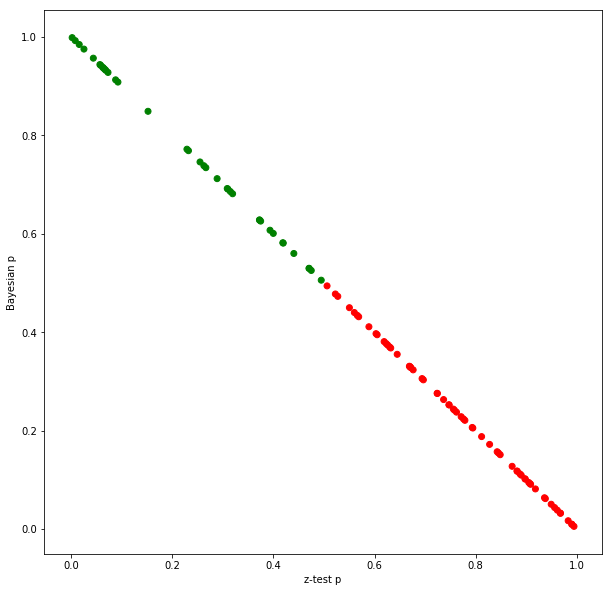

In [262]:
funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
N = 1000
num_simulations = 100

results = run_simulations(funnels, N, num_simulations)

plt.figure(figsize=(10, 10))
plt.xlabel('z-test p')
plt.ylabel('Bayesian p')
plt.scatter(x=take(results, 1), y=take(results, 2), c=take(results, 3))
plt.show()

[Text(0,0.5,'Bayesian p'), Text(0.5,0,'z-test p')]

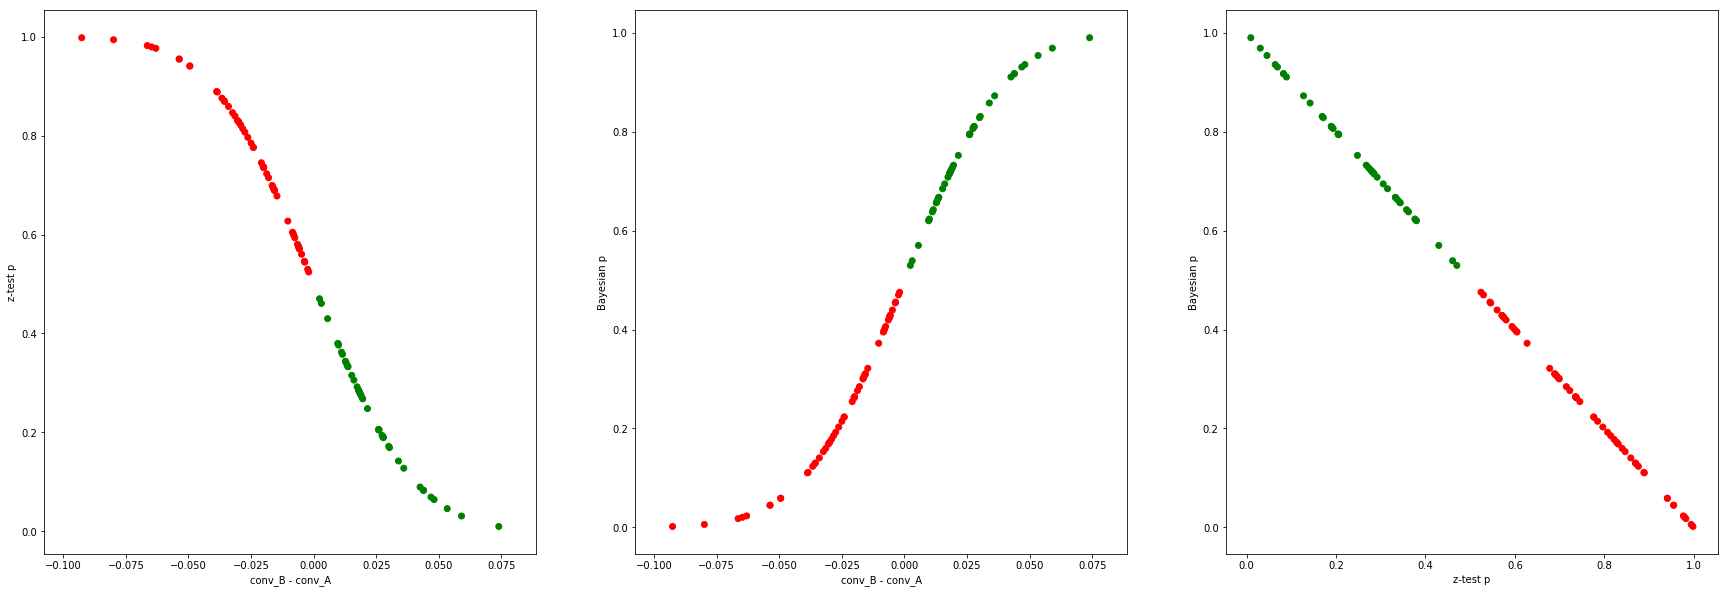

In [265]:
funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
N = 1000
num_simulations = 100

results = run_simulations(funnels, N, num_simulations)

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(30, 10))
plt1.scatter(x=take(results, 0), y=take(results, 1), c=take(results, 3))
plt1.set(xlabel='conv_B - conv_A', ylabel='z-test p')
plt2.scatter(x=take(results, 0), y=take(results, 2), c=take(results, 3))
plt2.set(xlabel='conv_B - conv_A', ylabel='Bayesian p')
plt3.scatter(x=take(results, 1), y=take(results, 2), c=take(results, 3))
plt3.set(xlabel='z-test p', ylabel='Bayesian p')

[Text(0,0.5,'Bayesian p'), Text(0.5,0,'z-test p')]

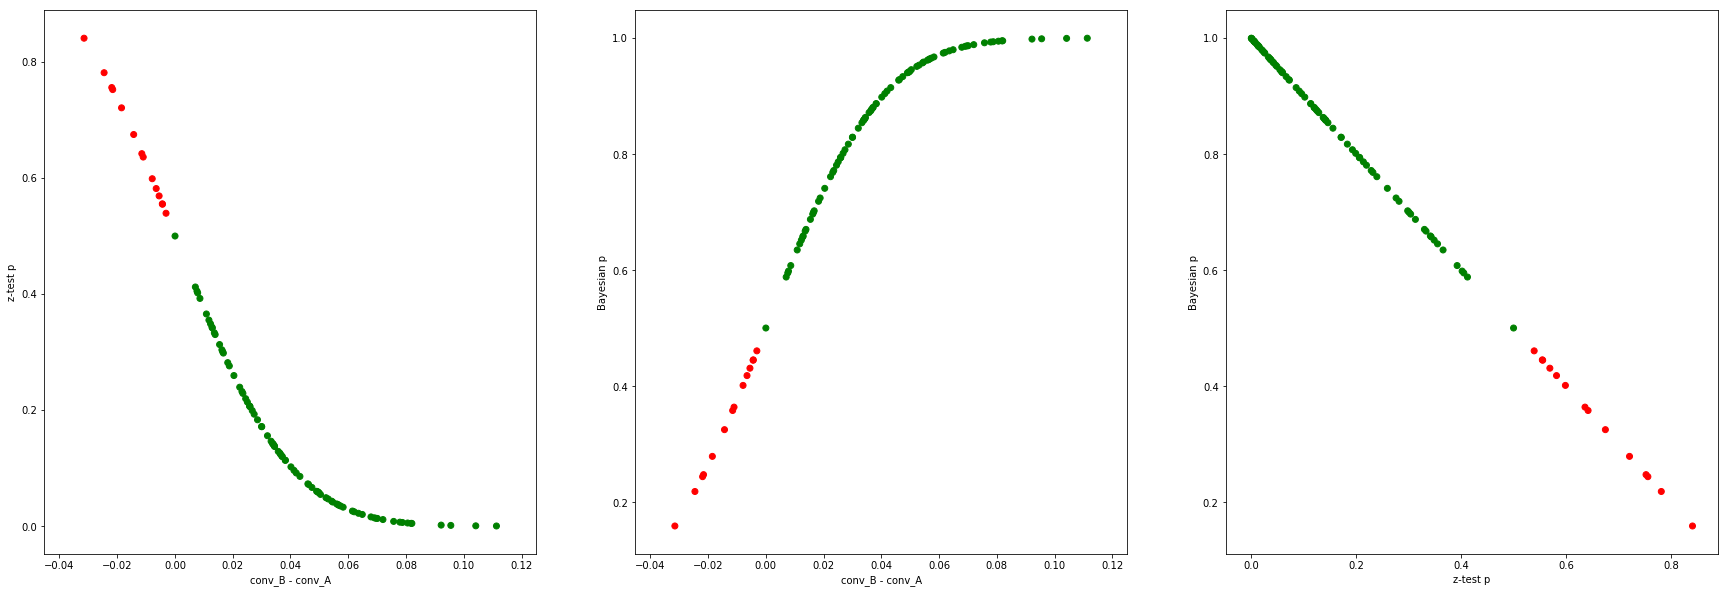

In [266]:
funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.47, 0.53], 0.5], # the second is the traffic split
]
N = 1000
num_simulations = 100

results = run_simulations(funnels, N, num_simulations)

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(30, 10))
plt1.scatter(x=take(results, 0), y=take(results, 1), c=take(results, 3))
plt1.set(xlabel='conv_B - conv_A', ylabel='z-test p')
plt2.scatter(x=take(results, 0), y=take(results, 2), c=take(results, 3))
plt2.set(xlabel='conv_B - conv_A', ylabel='Bayesian p')
plt3.scatter(x=take(results, 1), y=take(results, 2), c=take(results, 3))
plt3.set(xlabel='z-test p', ylabel='Bayesian p')

[Text(0,0.5,'Bayesian p'), Text(0.5,0,'t-test p')]

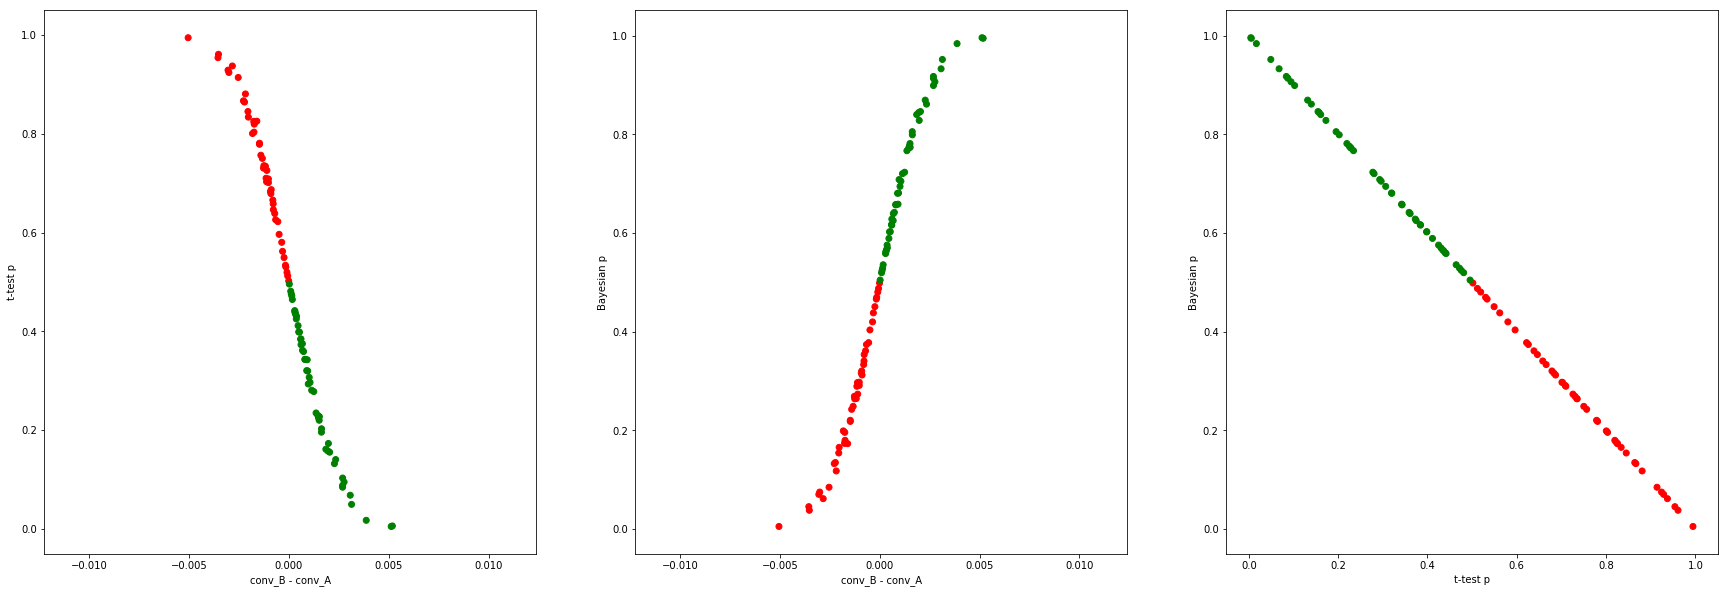

In [161]:
funnels = [
    [[0.99, 0.01], 0.5], # the first vector is the actual outcomes,
    [[0.99, 0.01], 0.5], # the second is the traffic split
]
N = 10*1000
num_simulations = 100

results = run_simulations(funnels, N, num_simulations)

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(30, 10))
plt1.scatter(x=take(results, 0), y=take(results, 1), c=take(results, 3))
plt1.set(xlabel='conv_B - conv_A', ylabel='t-test p')
plt2.scatter(x=take(results, 0), y=take(results, 2), c=take(results, 3))
plt2.set(xlabel='conv_B - conv_A', ylabel='Bayesian p')
plt3.scatter(x=take(results, 1), y=take(results, 2), c=take(results, 3))
plt3.set(xlabel='t-test p', ylabel='Bayesian p')

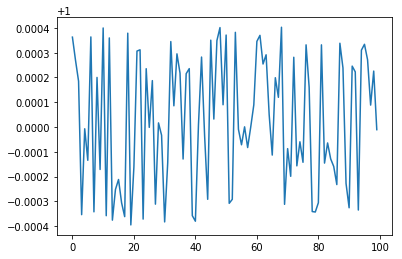

In [309]:
funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
N = 1000
num_simulations = 100

results = run_simulations(funnels, N, num_simulations)
plt.plot([x[1]+x[2] for x in results])

[Text(0,0.5,'Bayesian p'), Text(0.5,0,'t-test p')]

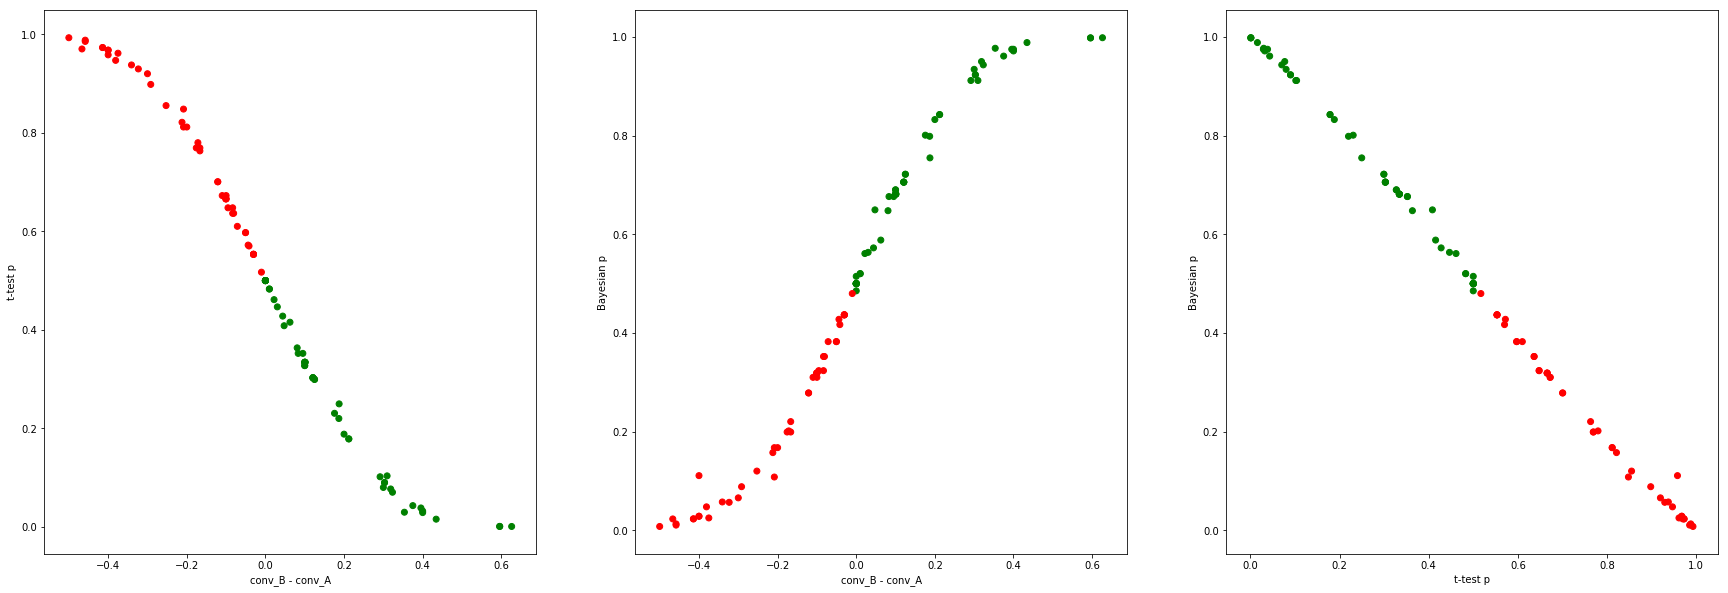

In [171]:
funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
N = 20
num_simulations = 100

results = run_simulations(funnels, N, num_simulations)

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(30, 10))
plt1.scatter(x=take(results, 0), y=take(results, 1), c=take(results, 3))
plt1.set(xlabel='conv_B - conv_A', ylabel='t-test p')
plt2.scatter(x=take(results, 0), y=take(results, 2), c=take(results, 3))
plt2.set(xlabel='conv_B - conv_A', ylabel='Bayesian p')
plt3.scatter(x=take(results, 1), y=take(results, 2), c=take(results, 3))
plt3.set(xlabel='t-test p', ylabel='Bayesian p')

[Text(0,0.5,'Bayesian p'), Text(0.5,0,'Fishers exact p')]

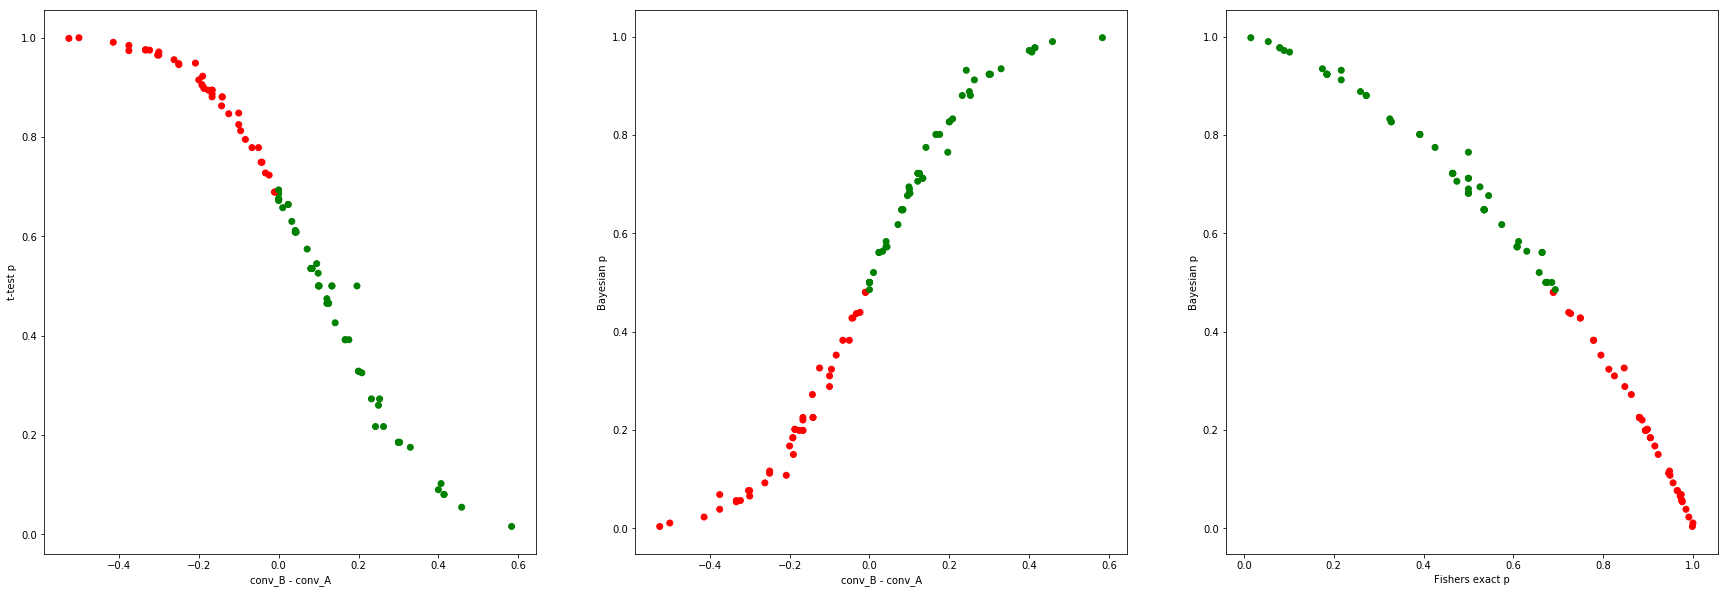

In [180]:
funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
N = 20
num_simulations = 100

def run_simulations(funnels, N, num_simulations):
    results = []
    for _ in range(num_simulations):
        observations = simulate_abtest(funnels, N)
        fp = fisher_exact(observations, alternative='greater')[1]
        bp = bayesian_prob(observations)
        conv_A = conversion(observations[0])
        conv_B = conversion(observations[1])
        results.append((conv_B - conv_A, fp, bp, 'green' if conv_A <= conv_B else 'red'))
    return results

results = run_simulations(funnels, N, num_simulations)

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(30, 10))
plt1.scatter(x=take(results, 0), y=take(results, 1), c=take(results, 3))
plt1.set(xlabel='conv_B - conv_A', ylabel='t-test p')
plt2.scatter(x=take(results, 0), y=take(results, 2), c=take(results, 3))
plt2.set(xlabel='conv_B - conv_A', ylabel='Bayesian p')
plt3.scatter(x=take(results, 1), y=take(results, 2), c=take(results, 3))
plt3.set(xlabel='Fisher exact p', ylabel='Bayesian p')

[Text(0,0.5,'Bayesian p'), Text(0.5,0,'t-test p')]

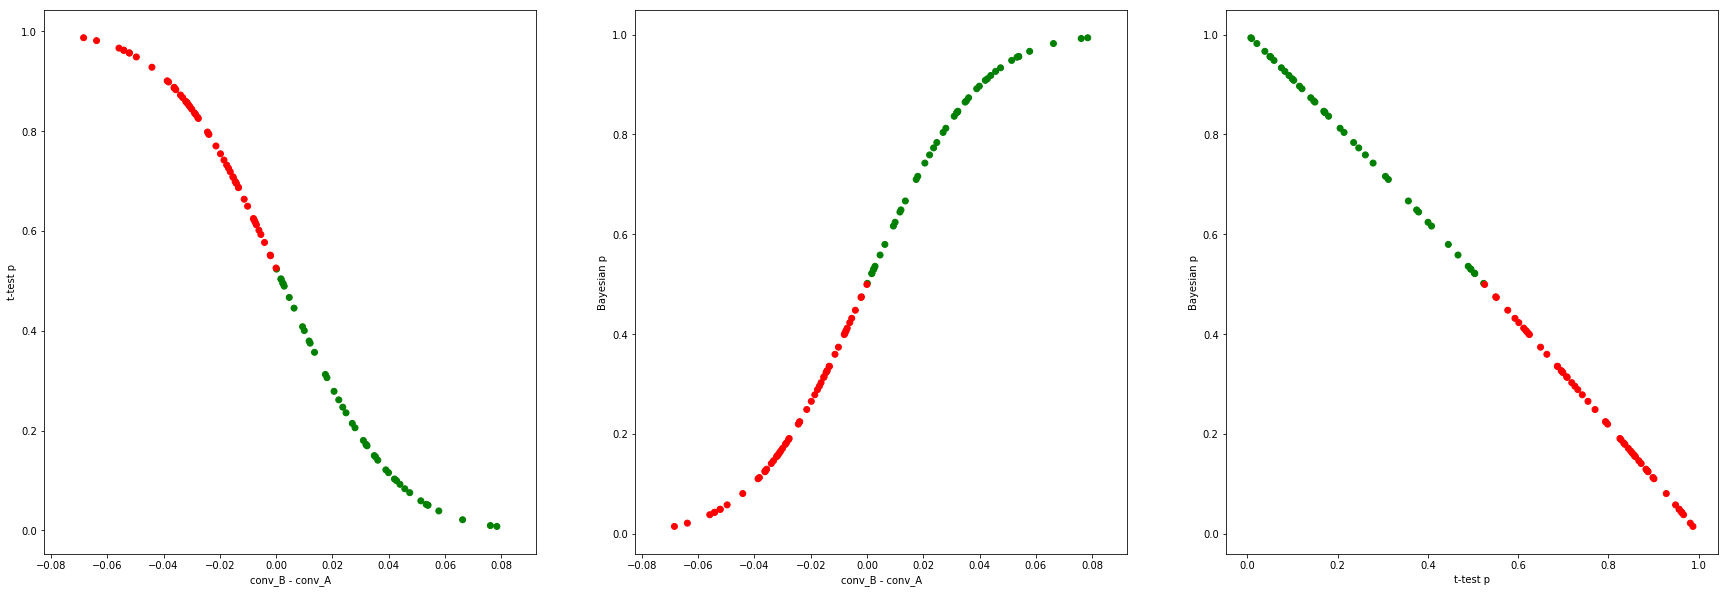

In [178]:
funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
N = 1000
num_simulations = 100

def run_simulations(funnels, N, num_simulations):
    results = []
    for _ in range(num_simulations):
        observations = simulate_abtest(funnels, N)
        fp = fisher_exact(observations, alternative='greater')[1]
        bp = bayesian_prob(observations)
        conv_A = conversion(observations[0])
        conv_B = conversion(observations[1])
        results.append((conv_B - conv_A, fp, bp, 'green' if conv_A <= conv_B else 'red'))
    return results

results = run_simulations(funnels, N, num_simulations)

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(30, 10))
plt1.scatter(x=take(results, 0), y=take(results, 1), c=take(results, 3))
plt1.set(xlabel='conv_B - conv_A', ylabel='t-test p')
plt2.scatter(x=take(results, 0), y=take(results, 2), c=take(results, 3))
plt2.set(xlabel='conv_B - conv_A', ylabel='Bayesian p')
plt3.scatter(x=take(results, 1), y=take(results, 2), c=take(results, 3))
plt3.set(xlabel='Fisher exact p', ylabel='Bayesian p')

Text(0.5,1,'N=10000, conv=0.1')

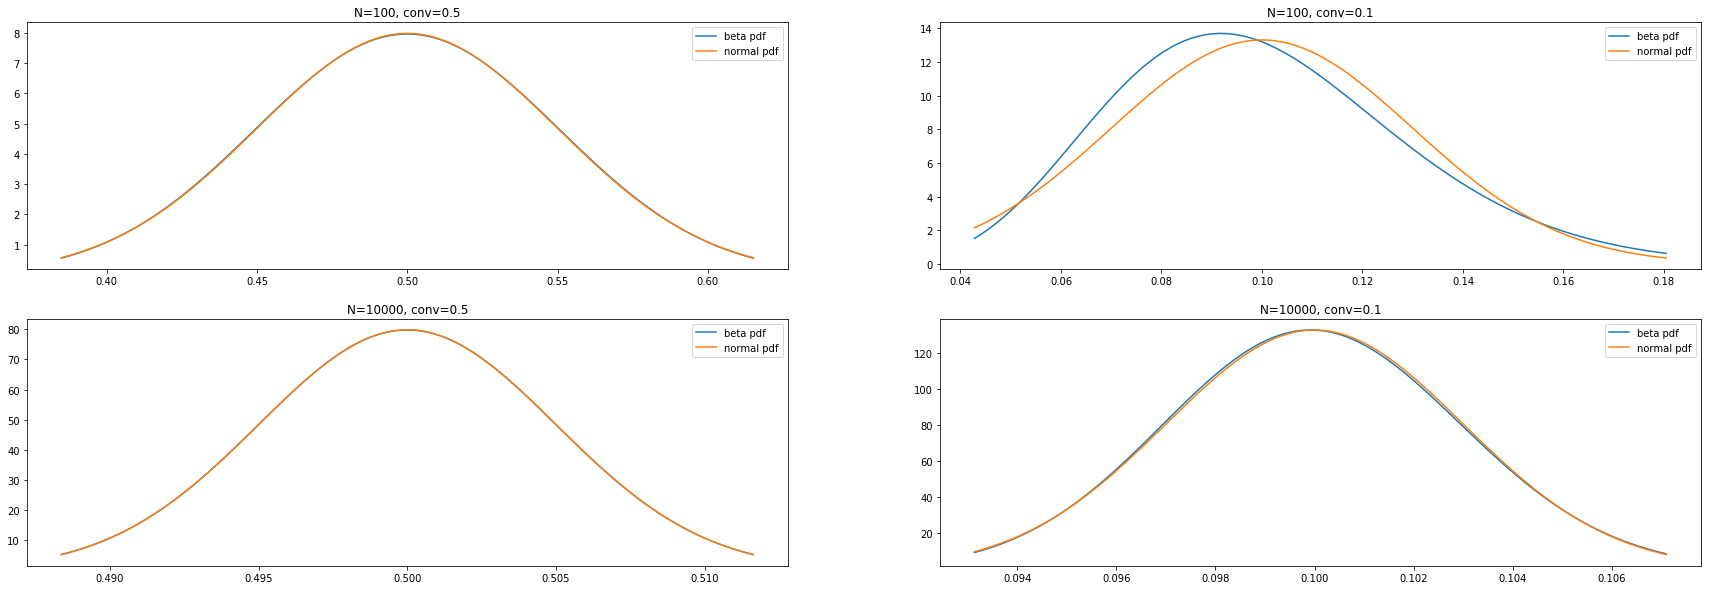

In [211]:
fig, ((plt1, plt2), (plt3, plt4)) = plt.subplots(2, 2, figsize=(30, 10))

N=100
conv=0.50
x = np.linspace(beta.ppf(0.01, conv*N, (1-conv)*N), beta.ppf(0.99, conv*N, (1-conv)*N), 100)
plt1.plot(x, beta.pdf(x, conv*N, (1-conv)*N))
plt1.plot(x, norm.pdf(x, conv, sqrt(conv * (1 - conv) / N)))
plt1.legend(['beta pdf', 'normal pdf'])
plt1.set_title('N=%s, conv=%s' % (N, conv))

N=100
conv=0.10
x = np.linspace(beta.ppf(0.01, conv*N, (1-conv)*N), beta.ppf(0.99, conv*N, (1-conv)*N), 100)
plt2.plot(x, beta.pdf(x, conv*N, (1-conv)*N))
plt2.plot(x, norm.pdf(x, conv, sqrt(conv * (1 - conv) / N)))
plt2.legend(['beta pdf', 'normal pdf'])
plt2.set_title('N=%s, conv=%s' % (N, conv))

N=10000
conv=0.50
x = np.linspace(beta.ppf(0.01, conv*N, (1-conv)*N), beta.ppf(0.99, conv*N, (1-conv)*N), 100)
plt3.plot(x, beta.pdf(x, conv*N, (1-conv)*N))
plt3.plot(x, norm.pdf(x, conv, sqrt(conv * (1 - conv) / N)))
plt3.legend(['beta pdf', 'normal pdf'])
plt3.set_title('N=%s, conv=%s' % (N, conv))

N=10000
conv=0.10
x = np.linspace(beta.ppf(0.01, conv*N, (1-conv)*N), beta.ppf(0.99, conv*N, (1-conv)*N), 100)
plt4.plot(x, beta.pdf(x, conv*N, (1-conv)*N))
plt4.plot(x, norm.pdf(x, conv, sqrt(conv * (1 - conv) / N)))
plt4.legend(['beta pdf', 'normal pdf'])
plt4.set_title('N=%s, conv=%s' % (N, conv))

[Text(0,0.5,'Bayesian p'), Text(0.5,0,'z-test p')]

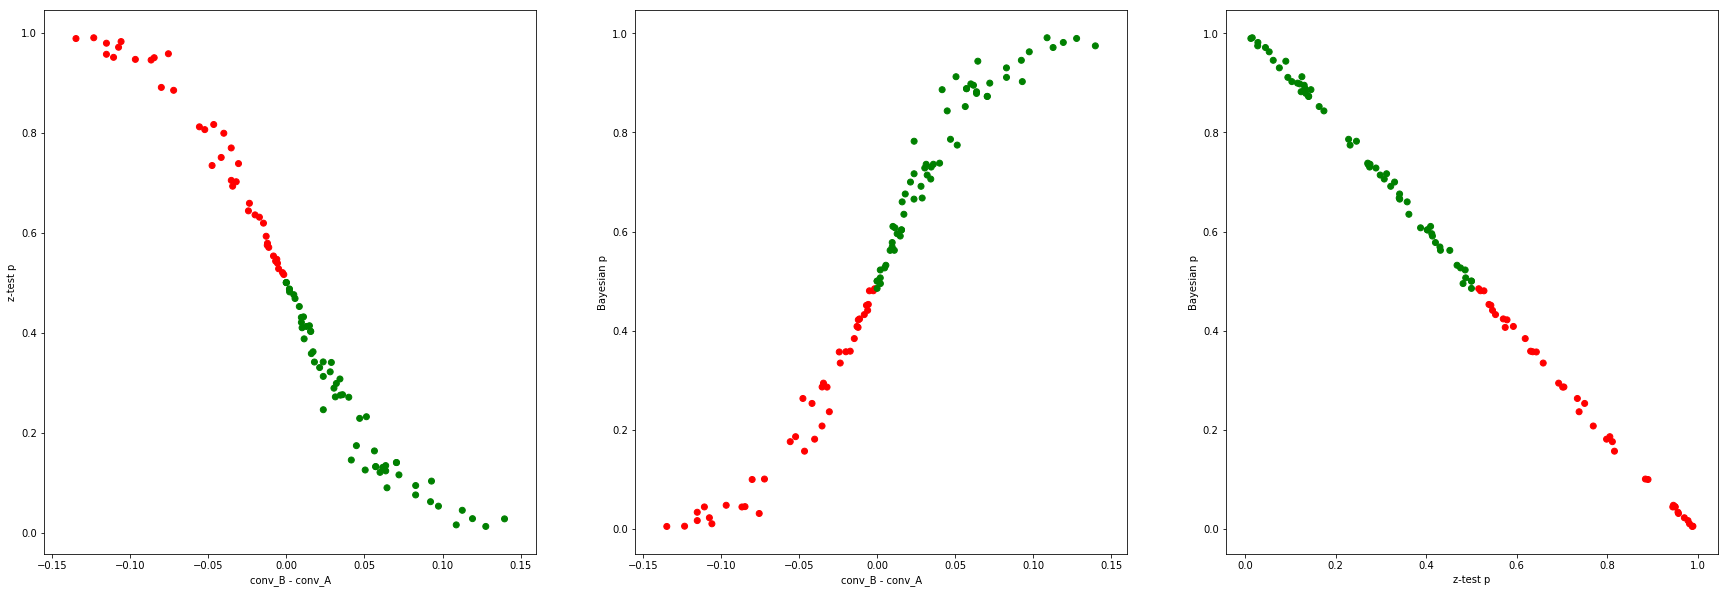

In [304]:
funnels = [
    [[0.90, 0.10], 0.5], # the first vector is the actual outcomes,
    [[0.90, 0.10], 0.5], # the second is the traffic split
]
N = 100
num_simulations = 100

results = run_simulations(funnels, N, num_simulations)

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(30, 10))
plt1.scatter(x=take(results, 0), y=take(results, 1), c=take(results, 3))
plt1.set(xlabel='conv_B - conv_A', ylabel='z-test p')
plt2.scatter(x=take(results, 0), y=take(results, 2), c=take(results, 3))
plt2.set(xlabel='conv_B - conv_A', ylabel='Bayesian p')
plt3.scatter(x=take(results, 1), y=take(results, 2), c=take(results, 3))
plt3.set(xlabel='z-test p', ylabel='Bayesian p')

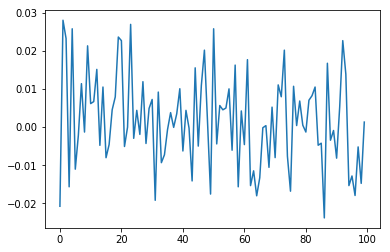

In [308]:
funnels = [
    [[0.90, 0.10], 0.5], # the first vector is the actual outcomes,
    [[0.90, 0.10], 0.5], # the second is the traffic split
]
N = 100
num_simulations = 100

results = run_simulations(funnels, N, num_simulations)
plt.plot([1-(x[1]+x[2]) for x in results])

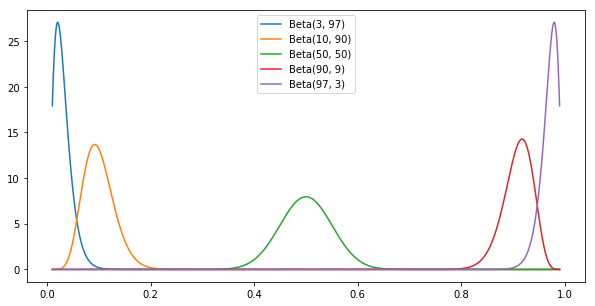

In [286]:
N = 100
convs = [0.03, 0.10, 0.50, 0.90, 0.97]
plt.figure(figsize=(10,5))
x = np.linspace(0.01, 0.99, 1000)
legends = []
for conv in convs:
    a = int(conv*N)
    b = int((1-conv)*N)
    plt.plot(x, beta.pdf(x, a, b))
    legends.append('Beta(%s, %s)' % (a, b))
plt.legend(legends)

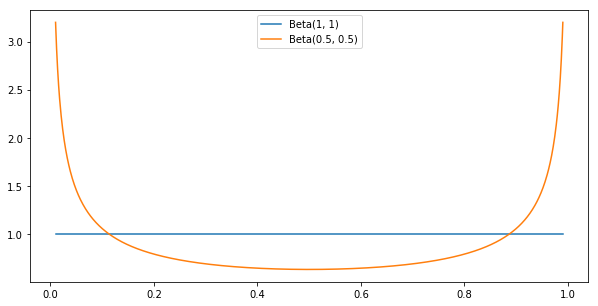

In [228]:
# common priors
plt.figure(figsize=(10,5))
x = np.linspace(0.01, 0.99, 1000)  
plt.plot(x, beta.pdf(x, 1, 1))
plt.plot(x, beta.pdf(x, 0.5, 0.5))
plt.legend(['Beta(1, 1)', 'Beta(0.5, 0.5)'])

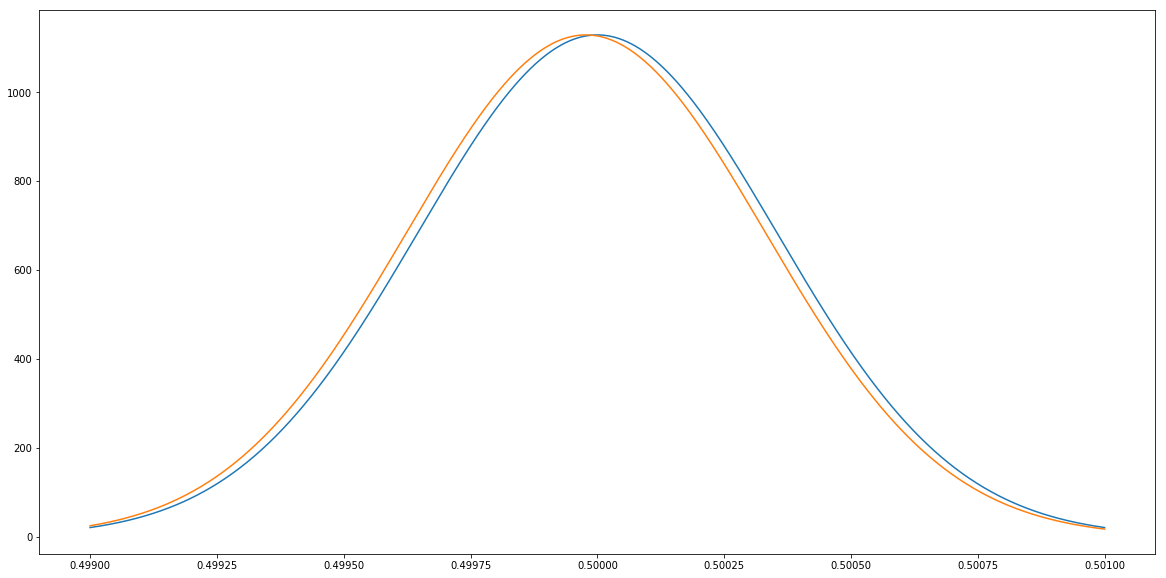

In [341]:
# common priors
plt.figure(figsize=(20, 10))
x = np.linspace(0.499, 0.501, 1000)
plt.plot(x, beta.pdf(x, 1000*1000, 1000*1000))
plt.plot(x, beta.pdf(x, 1000*1000+10, 1000*1000+100))